In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


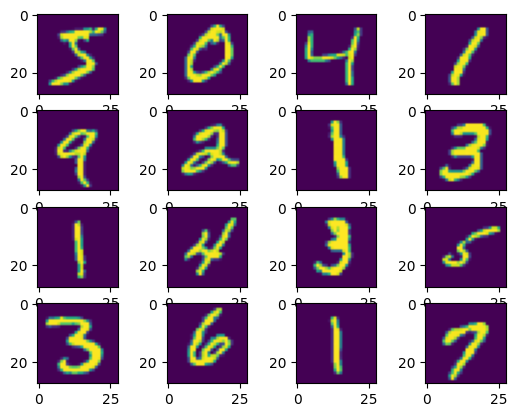

In [3]:
fig, axs = plt.subplots(4, 4)
cnt = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(X_train[cnt])
        cnt += 1

In [4]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

## Bayesian CNN specification

In [5]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters (mean and rho for std via softplus)
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).normal_(-3, 0.1))

        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).normal_(-3, 0.1))

    def forward(self, x):
        # Sample weights: w = mu + softplus(rho) * epsilon - equivilant to Normal sample - randomness htrough epsilon, so we can get gradients from mu and sigma
        weight_std = torch.log1p(torch.exp(self.weight_rho)) # backprop p instead of sigma - ensures sigma positive
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)

        # Sample bias
        bias_std = torch.log1p(torch.exp(self.bias_rho))
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        # Use the sampled weights in linear pytorch function
        return F.linear(x, weight, bias)

    def kl_divergence(self):
        # KL divergence between posterior q(w|theta) and prior p(w)
        weight_std = torch.log1p(torch.exp(self.weight_rho))
        bias_std = torch.log1p(torch.exp(self.bias_rho))

        kl = self._kl_divergence_normal(self.weight_mu, weight_std)
        kl += self._kl_divergence_normal(self.bias_mu, bias_std)
        return kl

    def _kl_divergence_normal(self, mu, std):
        # KL divergence between N(mu, std) and N(0, 1)
        kl = -torch.log(std) + (std**2 + mu**2) / 2 - 0.5
        return kl.sum()



In [6]:
class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super(BayesianConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.stride = stride

        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(
            out_channels, in_channels, *self.kernel_size).normal_(0, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(
            out_channels, in_channels, *self.kernel_size).normal_(-3, 0.1))

        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_channels).normal_(0, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels).normal_(-3, 0.1))

    def forward(self, x):
        weight_std = torch.log1p(torch.exp(self.weight_rho))
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)

        bias_std = torch.log1p(torch.exp(self.bias_rho))
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        return F.conv2d(x, weight, bias, stride=self.stride, padding=self.padding)

    def kl_divergence(self):
        weight_std = torch.log1p(torch.exp(self.weight_rho))
        bias_std = torch.log1p(torch.exp(self.bias_rho))

        return (self._kl_divergence_normal(self.weight_mu, weight_std) +
                self._kl_divergence_normal(self.bias_mu, bias_std))

    def _kl_divergence_normal(self, mu, std):
        kl = -torch.log(std) + (std**2 + mu**2) / 2 - 0.5
        return kl.sum()

In [7]:
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        # Conv block 1
        self.conv1 = BayesianConv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv block 2
        self.conv2 = BayesianConv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = BayesianLinear(7*7*16, 64)
        self.fc2 = BayesianLinear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def kl_divergence(self):
        # Total KL divergence for the network
        kl = 0
        kl += self.conv1.kl_divergence()
        kl += self.conv2.kl_divergence()
        kl += self.fc1.kl_divergence()
        kl += self.fc2.kl_divergence()
        return kl

    def predict_with_uncertainty(self, x, num_samples=100):
        self.train()  # Keep in train mode to sample weights
        predictions = []

        with torch.no_grad():
            for _ in range(num_samples):
                output = self(x)
                probs = F.softmax(output, dim=1)
                predictions.append(probs)

        predictions = torch.stack(predictions)  # [num_samples, batch_size, num_classes]

        mean_predictions = predictions.mean(dim=0)
        std_predictions = predictions.std(dim=0)

        return mean_predictions, std_predictions, predictions


In [8]:
class ParameterTracker:
    # Track specific parameters during training
    def __init__(self, model, num_params_to_track=10):
        self.history = {
            'conv1_weight_mu': [],
            'conv1_weight_sigma': [],
            'fc1_weight_mu': [],
            'fc1_weight_sigma': [],
            'fc2_bias_mu': [],
            'fc2_bias_sigma': [],
        }

        # Randomly select indices to track
        conv1_size = model.conv1.weight_mu.numel()
        fc1_size = model.fc1.weight_mu.numel()
        fc2_bias_size = model.fc2.bias_mu.numel()

        self.indices = {
            'conv1': np.random.choice(conv1_size, num_params_to_track, replace=False),
            'fc1': np.random.choice(fc1_size, num_params_to_track, replace=False),
            'fc2_bias': np.random.choice(fc2_bias_size, min(num_params_to_track, fc2_bias_size), replace=False),
        }

    def record(self, model):
        # Conv1 weights
        weight_mu = model.conv1.weight_mu.detach().cpu().flatten().numpy()
        weight_rho = model.conv1.weight_rho.detach().cpu().flatten().numpy()
        weight_sigma = np.log1p(np.exp(weight_rho))
        self.history['conv1_weight_mu'].append(weight_mu[self.indices['conv1']])
        self.history['conv1_weight_sigma'].append(weight_sigma[self.indices['conv1']])

        # FC1 weights
        weight_mu = model.fc1.weight_mu.detach().cpu().flatten().numpy()
        weight_rho = model.fc1.weight_rho.detach().cpu().flatten().numpy()
        weight_sigma = np.log1p(np.exp(weight_rho))
        self.history['fc1_weight_mu'].append(weight_mu[self.indices['fc1']])
        self.history['fc1_weight_sigma'].append(weight_sigma[self.indices['fc1']])

        # FC2 biases
        bias_mu = model.fc2.bias_mu.detach().cpu().numpy()
        bias_rho = model.fc2.bias_rho.detach().cpu().numpy()
        bias_sigma = np.log1p(np.exp(bias_rho))
        self.history['fc2_bias_mu'].append(bias_mu[self.indices['fc2_bias']])
        self.history['fc2_bias_sigma'].append(bias_sigma[self.indices['fc2_bias']])

    def plot_evolution(self):
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Parameter Evolution During Training', fontsize=16)

        epochs = np.arange(len(self.history['conv1_weight_mu']))

        # Conv1 weight mu
        for i in range(len(self.indices['conv1'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight_mu']]
            axes[0, 0].plot(epochs, mu_values, alpha=0.7, label=f'Weight {i}')
        axes[0, 0].set_title('Conv1 Weight μ Evolution')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('μ value')
        axes[0, 0].grid(alpha=0.3)

        # Conv1 weight sigma
        for i in range(len(self.indices['conv1'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight_sigma']]
            axes[0, 1].plot(epochs, sigma_values, alpha=0.7, label=f'Weight {i}')
        axes[0, 1].set_title('Conv1 Weight σ Evolution')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('σ value')
        axes[0, 1].grid(alpha=0.3)

        # FC1 weight mu
        for i in range(len(self.indices['fc1'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight_mu']]
            axes[1, 0].plot(epochs, mu_values, alpha=0.7)
        axes[1, 0].set_title('FC1 Weight μ Evolution')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('μ value')
        axes[1, 0].grid(alpha=0.3)

        # FC1 weight sigma
        for i in range(len(self.indices['fc1'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight_sigma']]
            axes[1, 1].plot(epochs, sigma_values, alpha=0.7)
        axes[1, 1].set_title('FC1 Weight σ Evolution')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('σ value')
        axes[1, 1].grid(alpha=0.3)

        # FC2 bias mu
        for i in range(len(self.indices['fc2_bias'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias_mu']]
            axes[2, 0].plot(epochs, mu_values, alpha=0.7, marker='o', markersize=3)
        axes[2, 0].set_title('FC2 Bias μ Evolution')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('μ value')
        axes[2, 0].grid(alpha=0.3)

        # FC2 bias sigma
        for i in range(len(self.indices['fc2_bias'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias_sigma']]
            axes[2, 1].plot(epochs, sigma_values, alpha=0.7, marker='o', markersize=3)
        axes[2, 1].set_title('FC2 Bias σ Evolution')
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('σ value')
        axes[2, 1].axhline(1, color='red', linestyle='--', alpha=0.5, label='Prior σ=1')
        axes[2, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BayesianCNN().to(device)

# Split training data into train and validation
val_size = 10000
train_size = len(X_train) - val_size

# Create validation set from last 10,000 samples
X_train_split = X_train[:train_size]
y_train_split = y_train[:train_size]
X_val = X_train[train_size:]
y_val = y_train[train_size:]


# Prepare training data (50,000 samples)
X_train_gpu = torch.FloatTensor(X_train_split).permute(0, 3, 1, 2).to(device)
y_train_gpu = torch.LongTensor(y_train_split).to(device)
train_dataset = TensorDataset(X_train_gpu, y_train_gpu)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Prepare validation data (10,000 samples)
X_val_gpu = torch.FloatTensor(X_val).permute(0, 3, 1, 2).to(device)
y_val_gpu = torch.LongTensor(y_val).to(device)
val_dataset = TensorDataset(X_val_gpu, y_val_gpu)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tracker = ParameterTracker(model, num_params_to_track=10)
tracker.record(model)

beta = 1.0 / len(X_train_split)  # 1/50000 = 0.00002
print(f"Beta: {beta:.8f}")
print(f"Num batches: {len(train_loader)}")

num_epochs = 50

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    total_nll = 0
    total_kl = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        nll_loss = F.cross_entropy(output, target)
        kl_loss = model.kl_divergence()
        loss = nll_loss + beta * kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_nll += nll_loss.item()
        total_kl += kl_loss.item()

    avg_loss = total_loss / len(train_loader)
    avg_nll = total_nll / len(train_loader)
    avg_kl = total_kl / len(train_loader)
    train_losses.append(avg_loss)

    # ============ VALIDATION ============
    model.eval()
    correct = 0
    total = 0
    predictions_count = np.zeros(10)

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            predictions_count += np.bincount(pred.cpu().numpy(), minlength=10)
            correct += (pred == target).sum().item()
            total += target.size(0)

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Record parameters after each epoch
    tracker.record(model)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Loss: {avg_loss:.4f} (NLL: {avg_nll:.4f}, KL: {avg_kl:.4f})')
        print(f'  Val Acc: {val_accuracy:.2f}%')
        print(f'  Predictions: {predictions_count.astype(int)}')



Using device: cuda
Beta: 0.00002000
Num batches: 391
Epoch 1/50:
  Loss: 3.5156 (NLL: 0.9516, KL: 128200.8066)
  Val Acc: 88.89%
  Predictions: [ 957 1097  903 1195 1001  795 1037 1097  902 1016]
Epoch 5/50:
  Loss: 2.2517 (NLL: 0.1229, KL: 106442.7610)
  Val Acc: 96.60%
  Predictions: [ 989 1080 1014 1008  982  904  960 1078 1014  971]
Epoch 10/50:
  Loss: 1.6554 (NLL: 0.0770, KL: 78917.1403)
  Val Acc: 97.45%
  Predictions: [ 994 1079  976 1035  973  890  981 1077 1012  983]
Epoch 15/50:
  Loss: 1.2513 (NLL: 0.0634, KL: 59393.3639)
  Val Acc: 97.71%
  Predictions: [ 995 1065  988 1016  988  898  975 1088 1011  976]
Epoch 20/50:
  Loss: 0.9979 (NLL: 0.0593, KL: 46929.1805)
  Val Acc: 97.65%
  Predictions: [ 986 1047  994 1047  983  919  978 1096 1012  938]
Epoch 25/50:
  Loss: 0.8163 (NLL: 0.0533, KL: 38151.2706)
  Val Acc: 97.65%
  Predictions: [ 994 1071  994 1024  973  906  976 1099 1006  957]
Epoch 30/50:
  Loss: 0.6850 (NLL: 0.0535, KL: 31579.1861)
  Val Acc: 97.84%
  Predictions

In [10]:
# ============ PREDICTIONS ============
model.eval()  # Set to evaluation mode (disables dropout, etc.)

# Prepare test data
X_test_gpu = torch.FloatTensor(X_test).permute(0, 3, 1, 2).to(device)
y_test_true = torch.LongTensor(y_test).to(device)

In [11]:
# Make predictions
with torch.no_grad():  # Disable gradient calculation (saves memory)
    outputs = model(X_test_gpu)
    _, predictions = torch.max(outputs, 1)  # Get class with highest score

# Move predictions back to CPU for sklearn
y_pred = predictions.cpu().numpy()

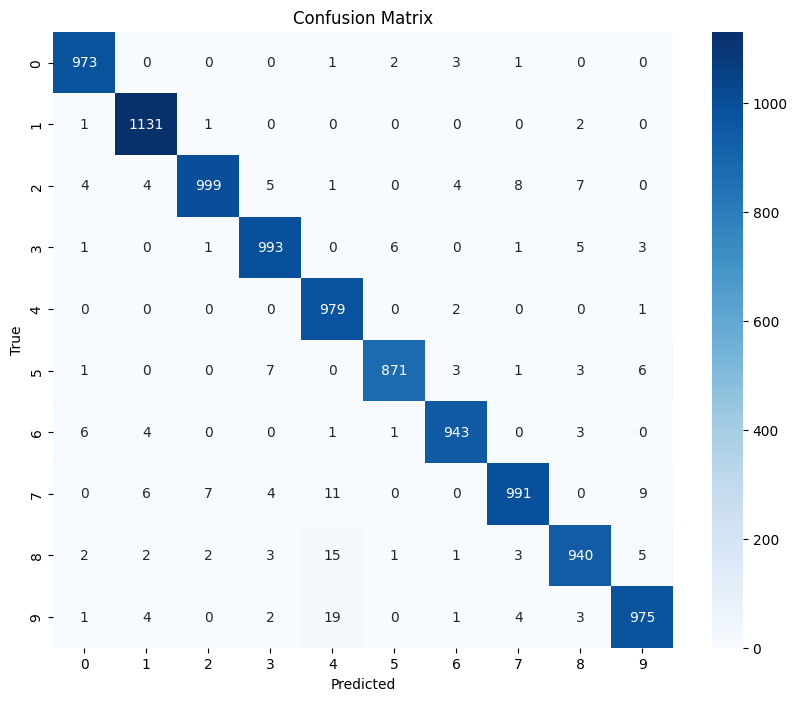

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.95      1.00      0.97       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Test Accuracy: 0.9795


In [12]:
# ============ CONFUSION MATRIX ============
from sklearn.metrics import confusion_matrix, classification_report

# Move tensors to CPU and convert to numpy
cm = confusion_matrix(y_test_true.cpu().numpy(), y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_true.cpu().numpy(), y_pred))

# Calculate accuracy
accuracy = (y_pred == y_test_true.cpu().numpy()).mean()
print(f"\nTest Accuracy: {accuracy:.4f}")

Total misclassified: 205


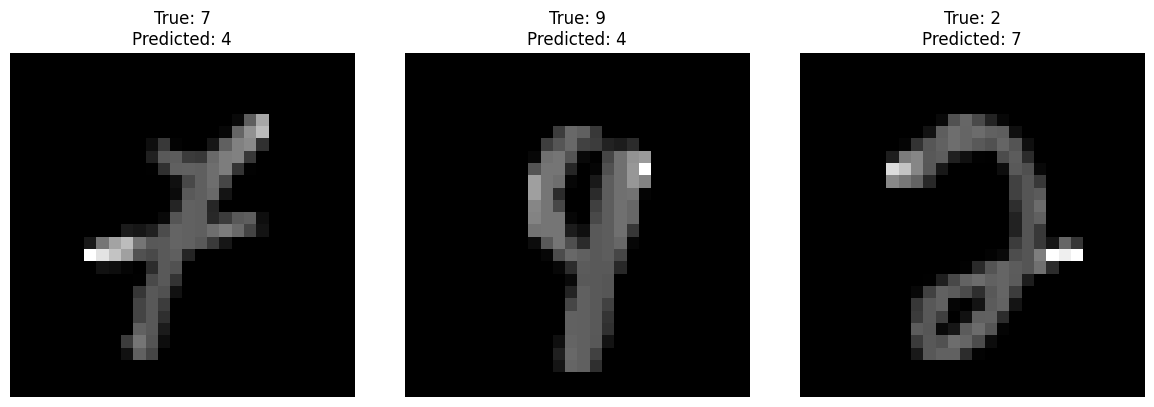

In [13]:
# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test_true.cpu().numpy())[0]

print(f"Total misclassified: {len(misclassified_idx)}")

# Select 3 random misclassified examples
n_examples = min(3, len(misclassified_idx))
random_idx = np.random.choice(misclassified_idx, n_examples, replace=False)

# Plot the misclassified images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(random_idx):
    axes[i].imshow(X_test[idx].squeeze(), cmap='gray')
    axes[i].set_title(f"True: {y_test_true.cpu().numpy()[idx]}\nPredicted: {y_pred[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
def plot_prediction_with_uncertainty(idx, is_correct):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the image
    axes[0].imshow(X_test[idx].squeeze(), cmap='gray')
    axes[0].set_title(f"{'CORRECT' if is_correct else 'INCORRECT'}\n"
                      f"True: {y_test_true_np[idx]}, Pred: {predicted_classes[idx]}\n"
                      f"Max Uncertainty: {max_uncertainties[idx]:.4f}")
    axes[0].axis('off')

    # Plot prediction probabilities with uncertainty bars
    classes = np.arange(10)
    axes[1].bar(classes, mean_preds[idx], alpha=0.7, label='Mean Probability')
    axes[1].errorbar(classes, mean_preds[idx], yerr=std_preds[idx],
                     fmt='none', ecolor='red', capsize=5, label='Uncertainty (±1 std)')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Prediction Distribution')
    axes[1].set_xticks(classes)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed stats
    print(f"\nDetailed stats for sample {idx}:")
    print(f"True label: {y_test_true_np[idx]}")
    print(f"Predicted label: {predicted_classes[idx]}")
    print(f"Confidence (max probability): {mean_preds[idx].max():.4f}")
    print(f"Uncertainty in prediction: {std_preds[idx][predicted_classes[idx]]:.4f}")
    print(f"Max uncertainty across classes: {max_uncertainties[idx]:.4f}")
    print("\nTop 3 predictions:")
    top3 = mean_preds[idx].argsort()[-3:][::-1]
    for rank, class_idx in enumerate(top3, 1):
        print(f"  {rank}. Class {class_idx}: {mean_preds[idx][class_idx]:.4f} ± {std_preds[idx][class_idx]:.4f}")


Correct predictions: 9900
Incorrect predictions: 100
CORRECT PREDICTION


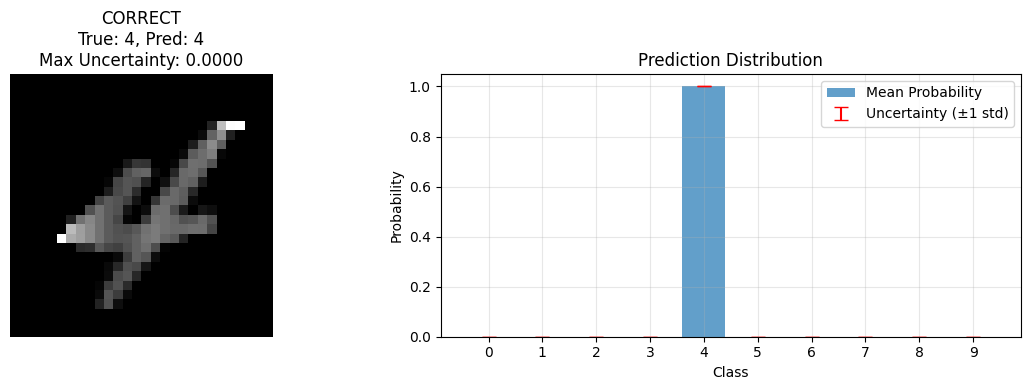


Detailed stats for sample 5055:
True label: 4
Predicted label: 4
Confidence (max probability): 1.0000
Uncertainty in prediction: 0.0000
Max uncertainty across classes: 0.0000

Top 3 predictions:
  1. Class 4: 1.0000 ± 0.0000
  2. Class 1: 0.0000 ± 0.0000
  3. Class 6: 0.0000 ± 0.0000

INCORRECT PREDICTION


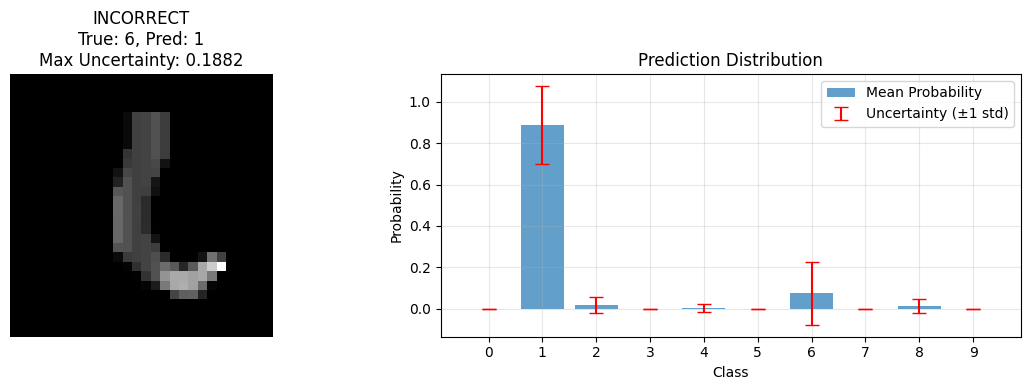


Detailed stats for sample 2654:
True label: 6
Predicted label: 1
Confidence (max probability): 0.8881
Uncertainty in prediction: 0.1882
Max uncertainty across classes: 0.1882

Top 3 predictions:
  1. Class 1: 0.8881 ± 0.1882
  2. Class 6: 0.0757 ± 0.1527
  3. Class 2: 0.0182 ± 0.0371


In [15]:
# Get predictions with uncertainty
model.eval()
X_test_gpu = torch.FloatTensor(X_test).permute(0, 3, 1, 2).to(device)

# Get uncertainty estimates - get a bunch of samples
mean_preds, std_preds, all_preds = model.predict_with_uncertainty(X_test_gpu, num_samples=30)

# Move everything to CPU and convert to numpy
mean_preds = mean_preds.cpu().numpy()
std_preds = std_preds.cpu().numpy()

y_test_true_np = y_test_true.cpu().numpy()

# Get predicted classes and their uncertainties
predicted_classes = mean_preds.argmax(axis=1)
max_uncertainties = std_preds.max(axis=1)  # Max uncertainty across all classes

# Find correctly and incorrectly classified examples
correct_idx = np.where(predicted_classes == y_test_true_np)[0]
incorrect_idx = np.where(predicted_classes != y_test_true_np)[0]

print(f"Correct predictions: {len(correct_idx)}")
print(f"Incorrect predictions: {len(incorrect_idx)}")

# Pick one correct and one incorrect prediction
correct_sample = np.random.choice(correct_idx)
incorrect_sample = np.random.choice(incorrect_idx)

# Visualize correct prediction
print("="*50)
print("CORRECT PREDICTION")
print("="*50)
plot_prediction_with_uncertainty(correct_sample, True)

# Visualize incorrect prediction
print("\n" + "="*50)
print("INCORRECT PREDICTION")
print("="*50)
plot_prediction_with_uncertainty(incorrect_sample, False)

## Looking at Weights, Bias uncertainty

/tmp/ipython-input-3851672840.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()
/tmp/ipython-input-3851672840.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 1].legend()


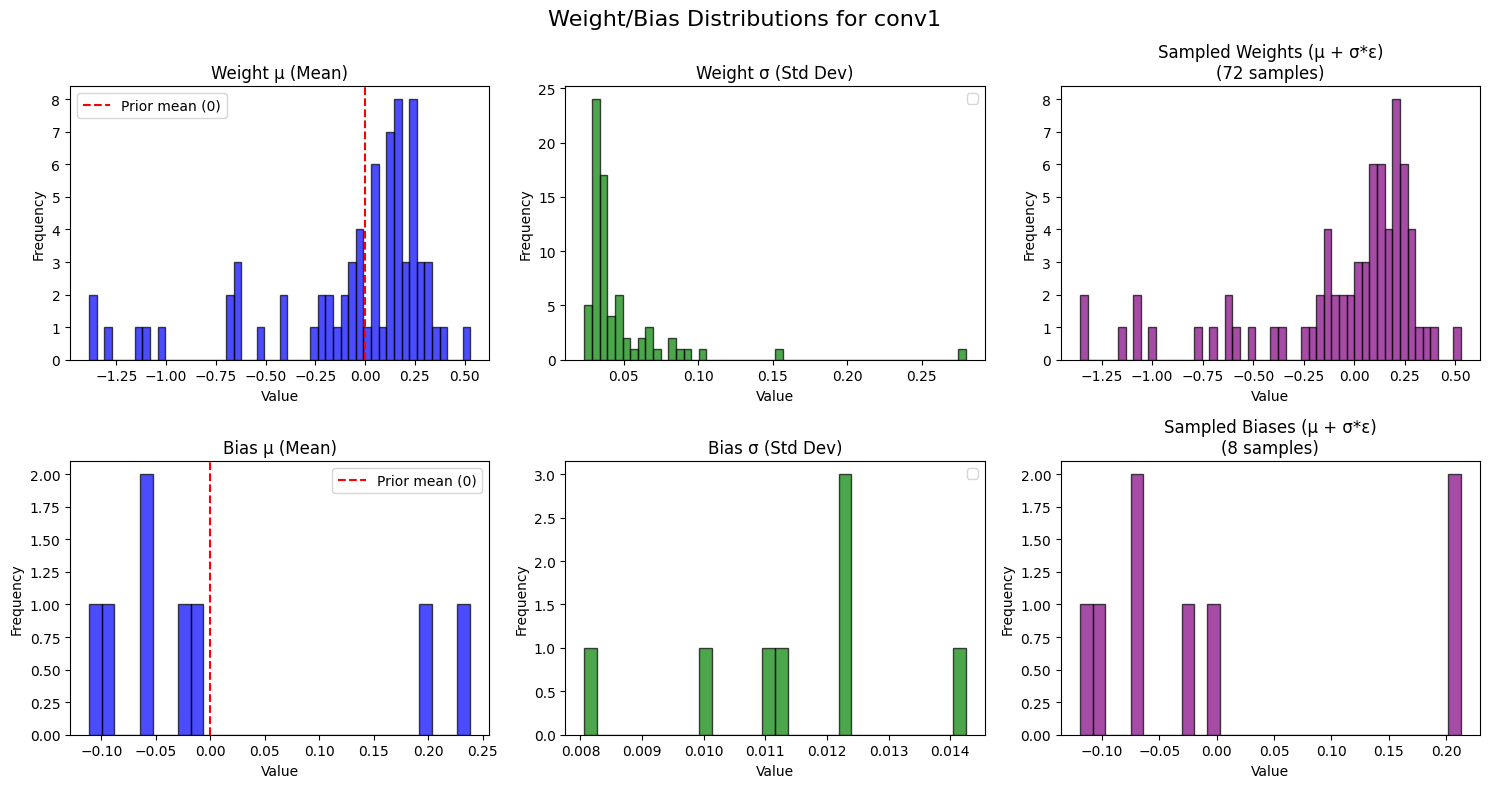


conv1 Statistics:
  Total weights: 72
  Total biases: 8
  Weight μ: mean=-0.0760, std=0.4362, min=-1.3871, max=0.5274
  Weight σ: mean=0.0469, std=0.0347, min=0.0237, max=0.2793
  Bias μ: mean=0.0101, std=0.1259
  Bias σ: mean=0.0115, std=0.0017


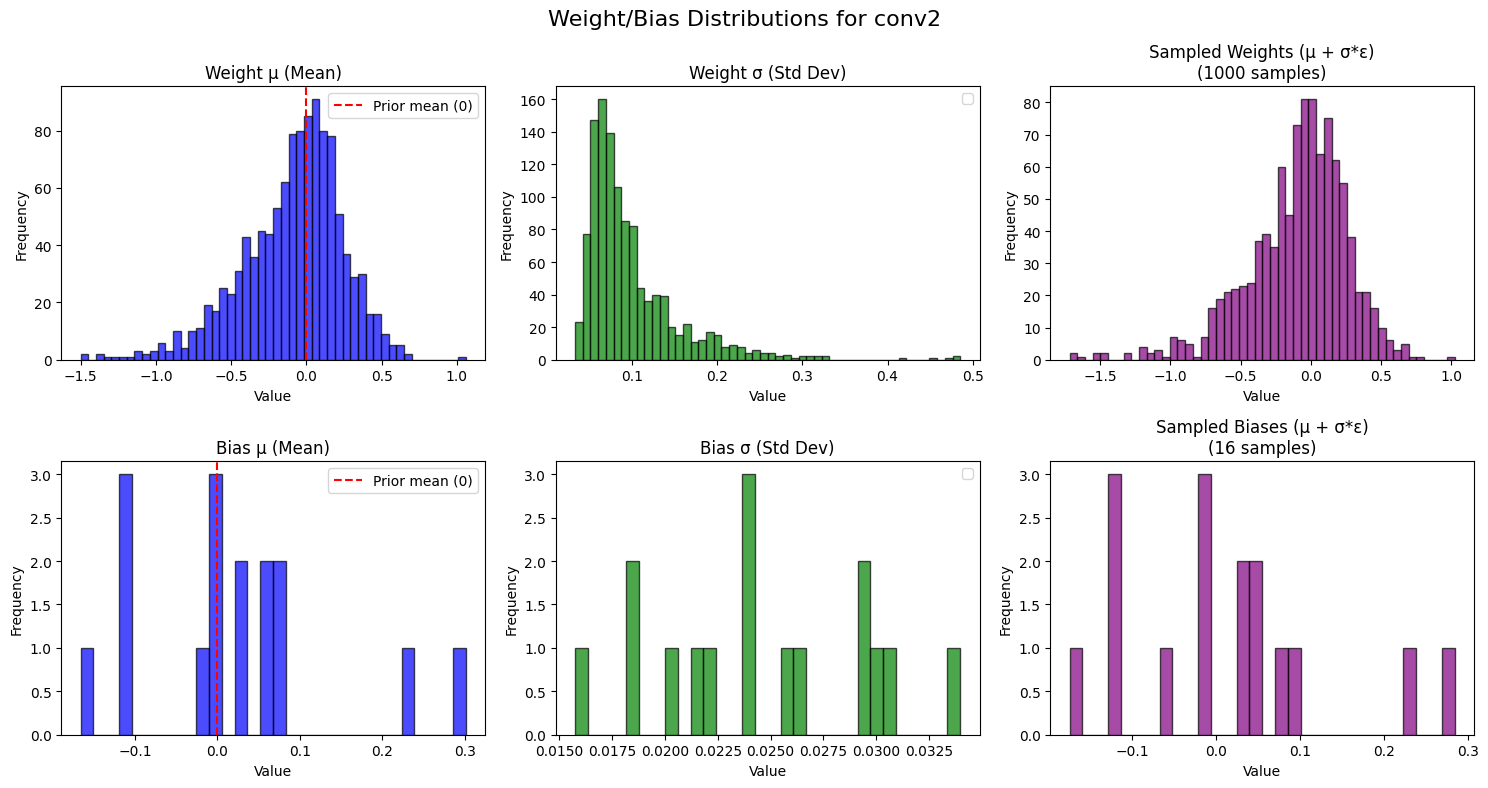


conv2 Statistics:
  Total weights: 1152
  Total biases: 16
  Weight μ: mean=-0.0917, std=0.3350, min=-1.5015, max=1.0588
  Weight σ: mean=0.0980, std=0.0560, min=0.0328, max=0.4855
  Bias μ: mean=0.0220, std=0.1189
  Bias σ: mean=0.0246, std=0.0050


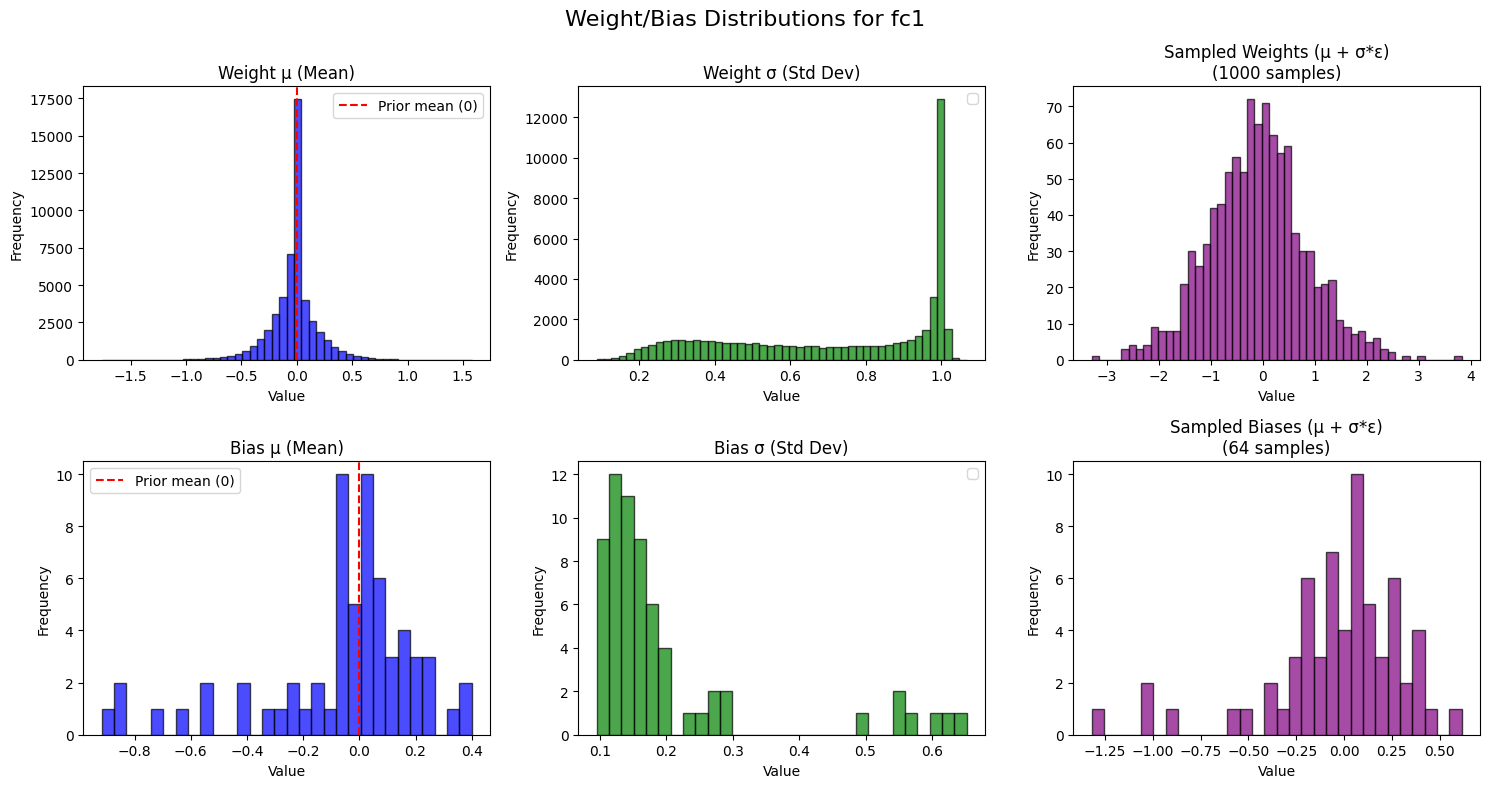


fc1 Statistics:
  Total weights: 50176
  Total biases: 64
  Weight μ: mean=-0.0259, std=0.2062, min=-1.7621, max=1.5774
  Weight σ: mean=0.7204, std=0.2817, min=0.0870, max=1.0673
  Bias μ: mean=-0.0666, std=0.2842
  Bias σ: mean=0.2014, std=0.1406


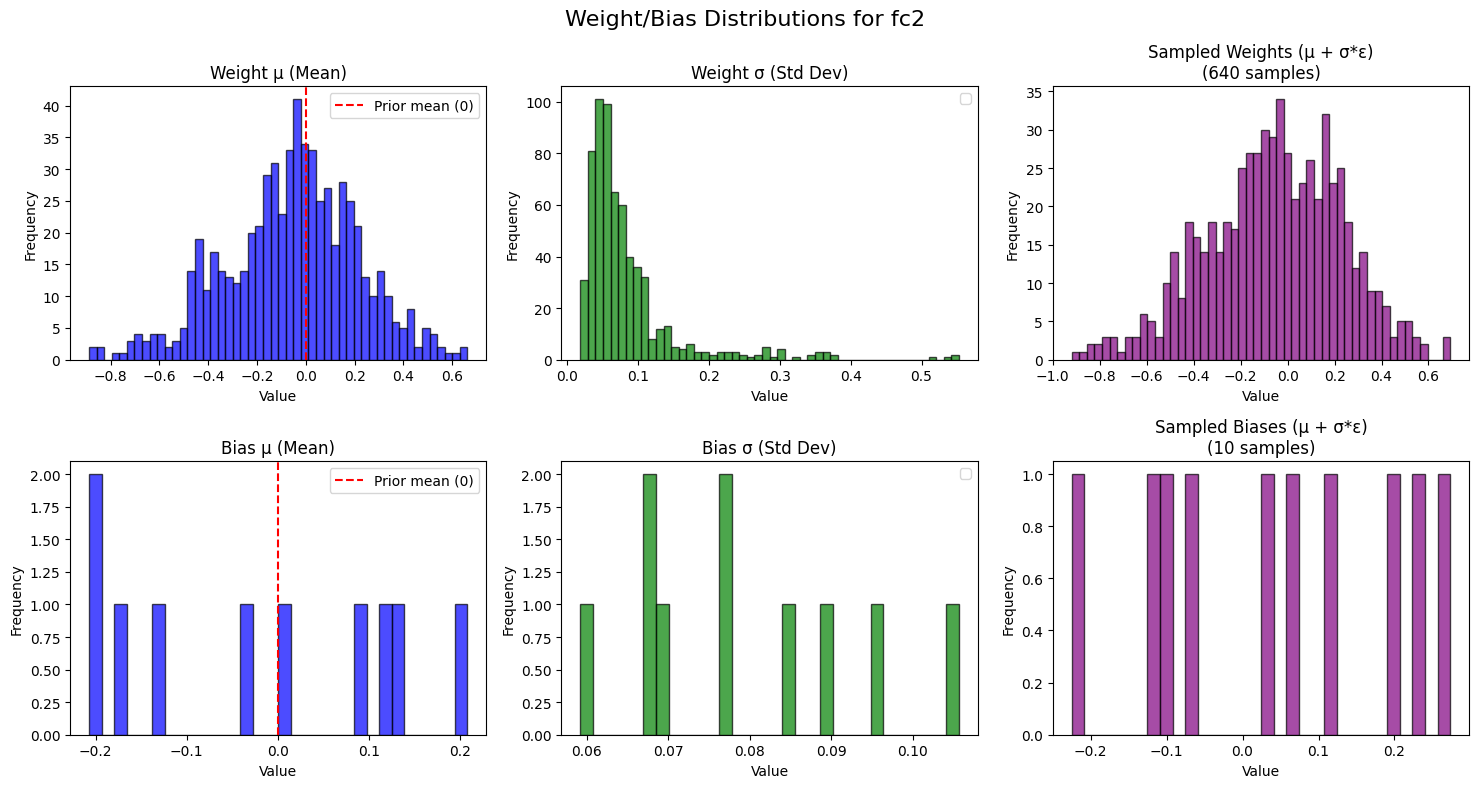


fc2 Statistics:
  Total weights: 640
  Total biases: 10
  Weight μ: mean=-0.0568, std=0.2703, min=-0.8884, max=0.6620
  Weight σ: mean=0.0839, std=0.0717, min=0.0182, max=0.5527
  Bias μ: mean=-0.0189, std=0.1466
  Bias σ: mean=0.0792, std=0.0136


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_weight_distributions(model, layer_name='conv1'):
    """Visualize the learned weight distributions (mu and sigma) for a layer"""

    # Get the layer
    if layer_name == 'conv1':
        layer = model.conv1
    elif layer_name == 'conv2':
        layer = model.conv2
    elif layer_name == 'fc1':
        layer = model.fc1
    elif layer_name == 'fc2':
        layer = model.fc2
    else:
        raise ValueError("Invalid layer name")

    # Get parameters
    weight_mu = layer.weight_mu.detach().cpu().numpy().flatten()
    weight_rho = layer.weight_rho.detach().cpu().numpy().flatten()
    weight_sigma = np.log1p(np.exp(weight_rho))  # Convert rho to sigma

    bias_mu = layer.bias_mu.detach().cpu().numpy()
    bias_rho = layer.bias_rho.detach().cpu().numpy()
    bias_sigma = np.log1p(np.exp(bias_rho))

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Weight/Bias Distributions for {layer_name}', fontsize=16)

    # Row 1: Weights
    # Mu distribution
    axes[0, 0].hist(weight_mu, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Weight μ (Mean)')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].axvline(0, color='red', linestyle='--', label='Prior mean (0)')
    axes[0, 0].legend()

    # Sigma distribution
    axes[0, 1].hist(weight_sigma, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Weight σ (Std Dev)')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

    # Sample from distribution - FIX: use all available weights
    num_samples = min(1000, len(weight_mu))  # Don't exceed available weights
    sampled_weights = weight_mu[:num_samples] + weight_sigma[:num_samples] * np.random.randn(num_samples)
    axes[0, 2].hist(sampled_weights, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].set_title(f'Sampled Weights (μ + σ*ε)\n({num_samples} samples)')
    axes[0, 2].set_xlabel('Value')
    axes[0, 2].set_ylabel('Frequency')

    # Row 2: Biases
    # Mu distribution
    axes[1, 0].hist(bias_mu, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[1, 0].set_title('Bias μ (Mean)')
    axes[1, 0].set_xlabel('Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(0, color='red', linestyle='--', label='Prior mean (0)')
    axes[1, 0].legend()

    # Sigma distribution
    axes[1, 1].hist(bias_sigma, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_title('Bias σ (Std Dev)')
    axes[1, 1].set_xlabel('Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()

    # Sample from distribution
    sampled_biases = bias_mu + bias_sigma * np.random.randn(len(bias_mu))
    axes[1, 2].hist(sampled_biases, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 2].set_title(f'Sampled Biases (μ + σ*ε)\n({len(bias_mu)} samples)')
    axes[1, 2].set_xlabel('Value')
    axes[1, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n{layer_name} Statistics:")
    print(f"  Total weights: {len(weight_mu)}")
    print(f"  Total biases: {len(bias_mu)}")
    print(f"  Weight μ: mean={weight_mu.mean():.4f}, std={weight_mu.std():.4f}, "
          f"min={weight_mu.min():.4f}, max={weight_mu.max():.4f}")
    print(f"  Weight σ: mean={weight_sigma.mean():.4f}, std={weight_sigma.std():.4f}, "
          f"min={weight_sigma.min():.4f}, max={weight_sigma.max():.4f}")
    print(f"  Bias μ: mean={bias_mu.mean():.4f}, std={bias_mu.std():.4f}")
    print(f"  Bias σ: mean={bias_sigma.mean():.4f}, std={bias_sigma.std():.4f}")

# Visualize each layer
visualize_weight_distributions(model, 'conv1')
visualize_weight_distributions(model, 'conv2')
visualize_weight_distributions(model, 'fc1')
visualize_weight_distributions(model, 'fc2')

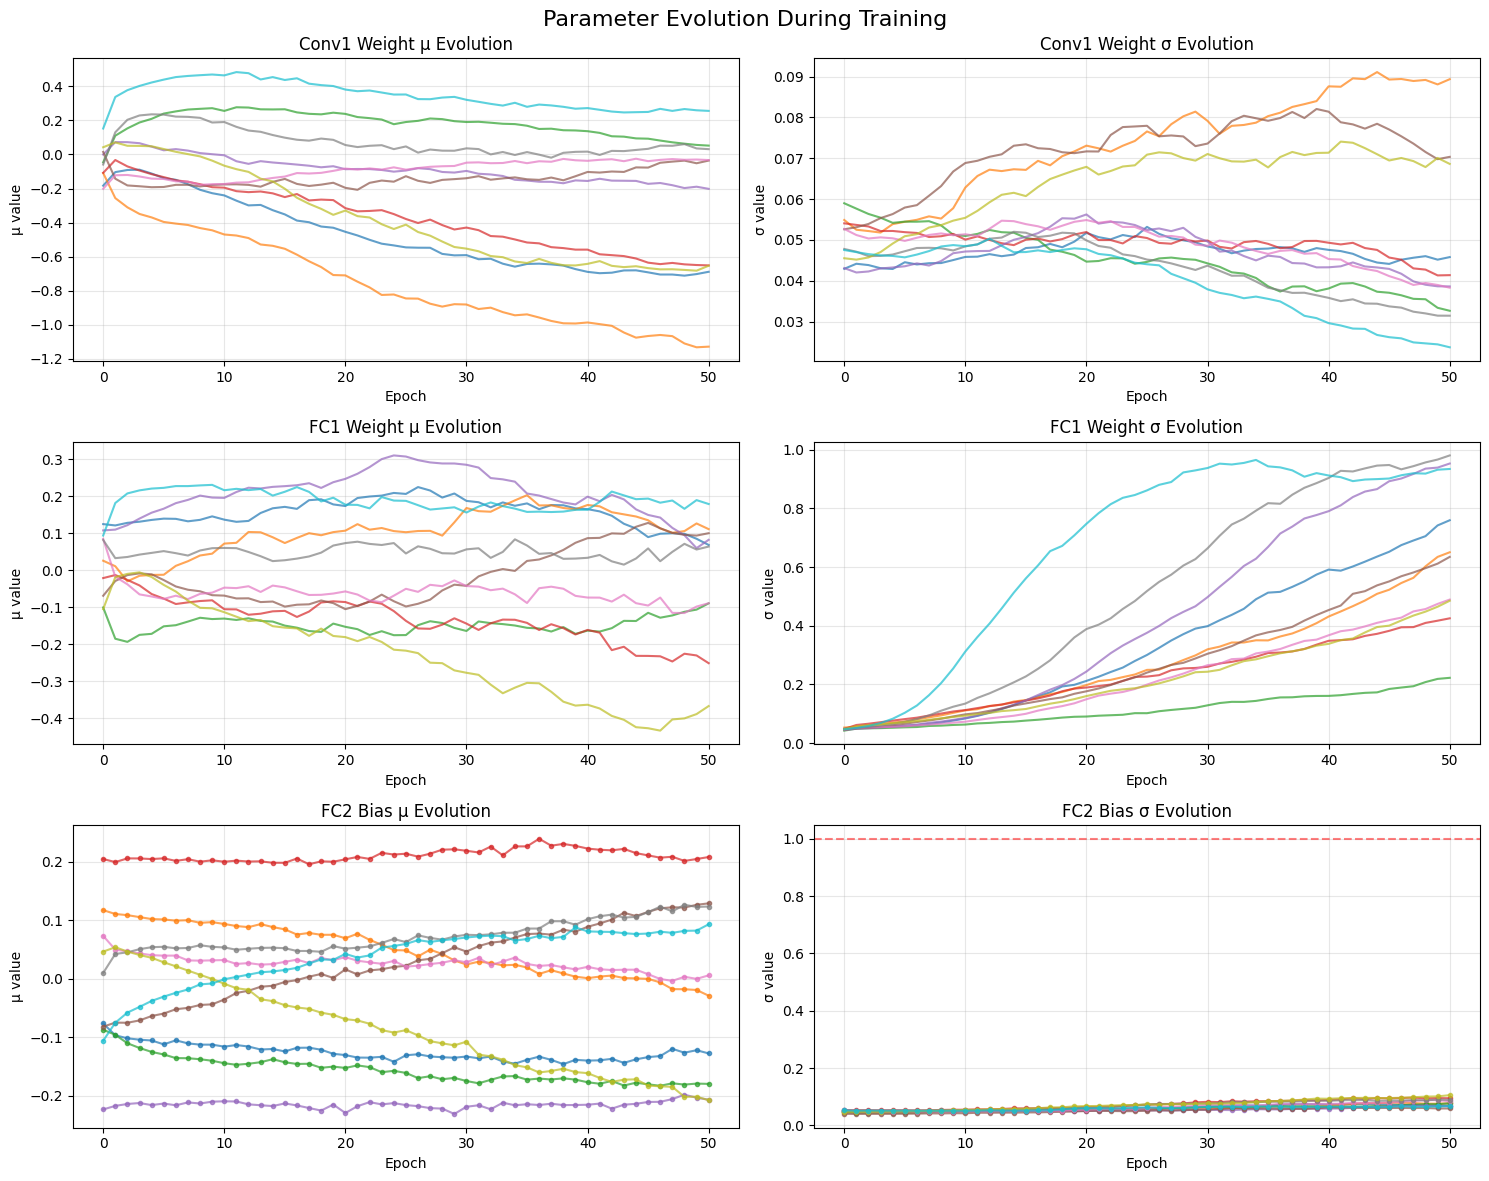

In [17]:
tracker.plot_evolution()